Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 24.001616
Minibatch accuracy: 4.7%
Validation accuracy: 10.8%
Minibatch loss at step 500: 2.594838
Minibatch accuracy: 80.5%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 1.861284
Minibatch accuracy: 75.0%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 1.450855
Minibatch accuracy: 73.4%
Validation accuracy: 80.2%
Minibatch loss at step 2000: 1.036859
Minibatch accuracy: 82.0%
Validation accuracy: 81.3%
Minibatch loss at step 2500: 0.746310
Minibatch accuracy: 81.2%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 0.817337
Minibatch accuracy: 80.5%
Validation accuracy: 81.5%
Test accuracy: 89.0%


#### finding the best beta value

In [7]:
num_steps = 3001
regul_val = [pow(10,i) for i in np.arange(-4,-2,0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: regul}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

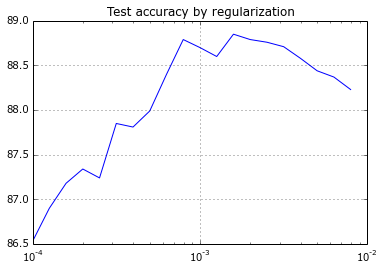

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization')
plt.show()

#### add 1-layer of relu

In [9]:
batch_size = 128
num_hidden_units = 1024

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_units]))
    biases1 = tf.Variable(tf.zeros([num_hidden_units]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 633.237549
Minibatch accuracy: 3.1%
Validation accuracy: 32.0%
Minibatch loss at step 500: 197.129822
Minibatch accuracy: 78.9%
Validation accuracy: 80.5%
Minibatch loss at step 1000: 117.527763
Minibatch accuracy: 77.3%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 69.296387
Minibatch accuracy: 78.1%
Validation accuracy: 81.0%
Minibatch loss at step 2000: 41.348621
Minibatch accuracy: 85.2%
Validation accuracy: 85.2%
Minibatch loss at step 2500: 25.259254
Minibatch accuracy: 85.9%
Validation accuracy: 86.2%
Minibatch loss at step 3000: 15.380573
Minibatch accuracy: 90.6%
Validation accuracy: 86.8%
Test accuracy: 93.0%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [11]:
batch_size = 128
num_hidden_units = 1024

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_units]))
    biases1 = tf.Variable(tf.zeros([num_hidden_units]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [12]:
num_steps = 3001
num_batches = 3
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = step % num_batches
    # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 659.548401
Minibatch accuracy: 7.0%
Validation accuracy: 30.9%
Minibatch loss at step 500: 191.545197
Minibatch accuracy: 100.0%
Validation accuracy: 65.1%
Minibatch loss at step 1000: 116.163574
Minibatch accuracy: 100.0%
Validation accuracy: 65.1%
Minibatch loss at step 1500: 70.447914
Minibatch accuracy: 100.0%
Validation accuracy: 65.1%
Minibatch loss at step 2000: 42.723495
Minibatch accuracy: 100.0%
Validation accuracy: 65.1%
Minibatch loss at step 2500: 25.909887
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 3000: 15.713236
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Test accuracy: 71.5%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [13]:
batch_size = 128
num_hidden_units = 1024

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_units]))
    biases1 = tf.Variable(tf.zeros([num_hidden_units]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_units, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [14]:
num_steps = 3001
num_batches = 3
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = step % num_batches
    # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul: 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 754.752197
Minibatch accuracy: 14.8%
Validation accuracy: 41.0%
Minibatch loss at step 500: 190.895859
Minibatch accuracy: 100.0%
Validation accuracy: 71.1%
Minibatch loss at step 1000: 115.790474
Minibatch accuracy: 100.0%
Validation accuracy: 71.0%
Minibatch loss at step 1500: 70.226028
Minibatch accuracy: 100.0%
Validation accuracy: 71.5%
Minibatch loss at step 2000: 42.589592
Minibatch accuracy: 100.0%
Validation accuracy: 71.8%
Minibatch loss at step 2500: 25.829050
Minibatch accuracy: 100.0%
Validation accuracy: 71.3%
Minibatch loss at step 3000: 15.664398
Minibatch accuracy: 100.0%
Validation accuracy: 71.5%
Test accuracy: 78.7%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [16]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 253
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():
    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1], stddev=np.sqrt(2.0 / (image_size * image_size))))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))    
    weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
    
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    logits = tf.matmul(lay2_train, weights3) + biases3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    
    
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [21]:
num_steps  = 18001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step%500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        
        
        

Minibatch loss at step 0: 3.292729
Minibatch accuracy: 8.6%
Validation accuracy: 40.3%
Minibatch loss at step 500: 0.965746
Minibatch accuracy: 87.5%
Validation accuracy: 85.0%
Minibatch loss at step 1000: 0.862125
Minibatch accuracy: 85.2%
Validation accuracy: 87.0%
Minibatch loss at step 1500: 0.788374
Minibatch accuracy: 83.6%
Validation accuracy: 87.7%
Minibatch loss at step 2000: 0.548730
Minibatch accuracy: 91.4%
Validation accuracy: 88.4%
Minibatch loss at step 2500: 0.557195
Minibatch accuracy: 90.6%
Validation accuracy: 88.8%
Minibatch loss at step 3000: 0.515178
Minibatch accuracy: 90.6%
Validation accuracy: 88.8%
Minibatch loss at step 3500: 0.548760
Minibatch accuracy: 89.1%
Validation accuracy: 89.4%
Minibatch loss at step 4000: 0.498945
Minibatch accuracy: 89.1%
Validation accuracy: 89.6%
Minibatch loss at step 4500: 0.481838
Minibatch accuracy: 89.1%
Validation accuracy: 89.7%
Minibatch loss at step 5000: 0.410481
Minibatch accuracy: 94.5%
Validation accuracy: 89.6%
Mini